# NCI Dream RNA-Seq Data Import

RNA-Seq data import for NCI DREAM drug sensitivity challenge.

Source data README: /Users/eczech/.synapseCache/428/756428/DREAM7_DrugSensitivity1_RNAseq_README.txt

Note that there are two forms of this data available, the "RNAseq_quantification.txt" which contains estimated gene expression levels from sequencing, as well as the "RNAseq_expressed_calls.txt" file which contains a binarized version of something similar (see the full README for more details)

In [1]:
%run -m ipy_startup
from mgds.data_aggregation import database as db
from mgds.data_aggregation import source as src
from mgds.data_aggregation import excel_utils
from mgds.data_aggregation.import_lib import nci_dream
from py_utils.collection_utils import subset
from py_utils import assertion_utils

In [2]:
file_path = nci_dream.get_file('RNAseq_quantification.txt')
d = pd.read_csv(file_path, sep='\t')

# At TOW, this data had no "Excel Dates" as gene ids so make sure that remains true
assert not np.any(excel_utils.is_excel_date(d['HGNC_ID']))

# Run manual conversions for known special cases in NCI Dream Gene Symbols
d['HGNC_ID'] = nci_dream.convert_hgnc_id(d['HGNC_ID'])

d.head()

,HGNC_ID,Ensembl_ID,184A1,184B5,21MT1,21NT,600MPE,AU565,BT474,BT483,...,SUM149PT,SUM159PT,SUM225CWN,SUM229PE,SUM52PE,T47D,UACC812,ZR751,ZR7530,ZR75B
0,TSPAN6,ENSG00000000003,95.212548,95.698676,19.994674,44.057746,178.158832,13.460144,37.879666,69.092581,...,34.322919,84.116269,30.797927,39.425097,129.418091,82.748694,26.579280,31.812999,121.459918,2.293898
1,NFYA,ENSG00000001167,89.512619,94.154375,245.433541,286.092419,125.193255,68.907655,167.815672,152.752421,...,77.391314,148.816160,101.402401,111.108369,102.457186,61.650437,138.140311,68.458022,73.910964,61.625519
2,ABCB4,ENSG00000005471,0.000000,0.172734,0.231762,0.000000,0.757785,2.976117,1.210384,1.670807,...,0.000000,3.098289,1.006138,0.000000,0.784523,1.261100,0.440649,0.548865,0.611036,0.556531
3,EML1,ENSG00000066629,24.701397,7.633869,5.842132,5.149179,29.604076,15.084108,30.669290,135.100074,...,0.000000,27.478616,22.957617,0.604542,90.533172,74.463574,79.187879,25.493800,25.917323,32.528112
4,ABCA9,ENSG00000154258,0.000000,2.683498,0.000000,0.000000,0.652424,0.000000,0.065451,0.000000,...,0.000000,0.031426,0.000000,0.096449,0.199749,0.000000,0.040907,0.000000,0.033571,0.177808


In [3]:
d = d.rename(columns={'HGNC_ID': 'GENE_ID:HGNC', 'Ensembl_ID': 'GENE_ID:ENSEMBL'})
id_vars = ['GENE_ID:HGNC', 'GENE_ID:ENSEMBL']

# assert d.groupby('GENE_ID:HGNC')['GENE_ID:ENSEMBL'].nunique().max() == 1
# assert d.groupby('GENE_ID:ENSEMBL')['GENE_ID:HGNC'].nunique().max() == 1

d = pd.melt(d, id_vars=id_vars, value_name='VALUE', var_name='CELL_LINE_ID')

# Ensure no gene + cell line combos are repeated
assert d.groupby(id_vars + ['CELL_LINE_ID']).size().max() == 1

# Remove records with null values
d = subset(d, lambda df: df[df['VALUE'].notnull()], subset_op='Remove null values for column "VALUE"')

# Ensure all objects are strings
assertion_utils.assert_object_types(d)

d.head()

[Remove null values for column "VALUE"] Records before = 1625932, Records after = 1625932, Records removed = 0 (%0.00)


,GENE_ID:HGNC,GENE_ID:ENSEMBL,CELL_LINE_ID,VALUE
0,TSPAN6,ENSG00000000003,184A1,95.212548
1,NFYA,ENSG00000001167,184A1,89.512619
2,ABCB4,ENSG00000005471,184A1,0.000000
3,EML1,ENSG00000066629,184A1,24.701397
4,ABCA9,ENSG00000154258,184A1,0.000000


In [4]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1625932 entries, 0 to 1625931
Data columns (total 4 columns):
GENE_ID:HGNC       1625932 non-null object
GENE_ID:ENSEMBL    1625932 non-null object
CELL_LINE_ID       1625932 non-null object
VALUE              1625932 non-null float64
dtypes: float64(1), object(3)
memory usage: 62.0+ MB


## Aggregate Measurement Replicates

In [5]:
d_agg = d.groupby(['CELL_LINE_ID', 'GENE_ID:HGNC'])['VALUE']\
    .agg({'VALUE_MEAN': np.mean, 'VALUE_STD': np.std, 'VALUE_CT': 'count'}).reset_index()
d_agg['VALUE_STD'] = d_agg['VALUE_STD'].fillna(0)
d_agg.head()

,CELL_LINE_ID,GENE_ID:HGNC,VALUE_CT,VALUE_MEAN,VALUE_STD
0,184A1,5S_rRNA,414,0.127688,1.071953
1,184A1,5_8S_rRNA,5,113.279618,253.300926
2,184A1,7SK,233,1.236219,15.977855
3,184A1,A1BG,1,0.304122,0.000000
4,184A1,A1CF,1,0.000000,0.000000


In [6]:
d_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1326776 entries, 0 to 1326775
Data columns (total 5 columns):
CELL_LINE_ID    1326776 non-null object
GENE_ID:HGNC    1326776 non-null object
VALUE_CT        1326776 non-null int64
VALUE_MEAN      1326776 non-null float64
VALUE_STD       1326776 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 50.6+ MB


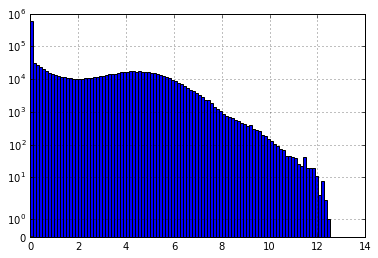

In [7]:
%matplotlib inline
ax = d_agg['VALUE_MEAN'].apply(np.log1p).hist(bins=100)
ax.set_yscale('symlog')

## Export

In [8]:
assertion_utils.assert_object_types(d_agg)
assert np.all(pd.notnull(d_agg))
db.save(d_agg, src.NCIDREAM_v1, db.IMPORT, 'gene-rna-seq')

'/Users/eczech/data/research/mgds/import/ncidream_v1_gene-rna-seq.pkl'